# Visual Question Answering ML Model on CLEVR dataset
This interactive notebook utilizes tensorflow to create a VQA ML model that takes the image and the questions and answers the questions. It ultilizes both CNN as well as RNN in order give predictions.

In [1]:
#importing necessary libraries and frameworks
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
# import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds


In [2]:
#Here we check is GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 0
Tensorflow GPU : False


In [3]:
print(tf.__version__)

2.15.0


# Loading the data from the JSON files 
Loading the json files using JSON module and using pandas to create a dataframe consisting of the path to the images and respective questions and answers to the images.

In [33]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
trainList=[]
with open('archive/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for i in data['questions']:
        temp=[]
        for path in glob.glob('archive/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

valList=[]
with open('archive/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for i in data['questions']:
        temp=[]
        for path in glob.glob('archive/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

Path  \
0  archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
1  archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
2  archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
3  archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
4  archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   

                                            Question Answer  
0  Are there any other things that are the same s...     no  
1  Is there a big brown object of the same shape ...    yes  
2     What is the material of the big purple object?  metal  
3  There is a small gray block; are there any sph...    yes  
4  Is the purple thing the same shape as the larg...     no

In [36]:
train_dataframe

Path  \
0       archive/CLEVR_v1.0/images/train/CLEVR_train_00...   
1       archive/CLEVR_v1.0/images/train/CLEVR_train_00...   
2       archive/CLEVR_v1.0/images/train/CLEVR_train_00...   
3       archive/CLEVR_v1.0/images/train/CLEVR_train_00...   
4       archive/CLEVR_v1.0/images/train/CLEVR_train_00...   
...                                                   ...   
699984  archive/CLEVR_v1.0/images/train/CLEVR_train_06...   
699985  archive/CLEVR_v1.0/images/train/CLEVR_train_06...   
699986  archive/CLEVR_v1.0/images/train/CLEVR_train_06...   
699987  archive/CLEVR_v1.0/images/train/CLEVR_train_06...   
699988  archive/CLEVR_v1.0/images/train/CLEVR_train_06...   

                                                 Question  Answer  
0       Are there more big green things than large pur...     yes  
1       How many other things are there of the same sh...       2  
2       Is the color of the large sphere the same as t...      no  
3       What material is the big object that is right ...  rubber  
4                      How big is the brown shiny sphere?   large  
...                                                   ...     ...  
699984  There is a ball that is the same color as the ...   metal  
699985  There is a purple cylinder; are there any gree...     yes  
699986  Are there any big cyan rubber things of the sa...      no  
699987  There is a green thing that is right of the pu...      no  
699988  Is there a brown rubber cylinder that has the ...      no  

[699989 rows x 3 columns]

In [37]:
val_dataframe

Path  \
0       archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
1       archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
2       archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
3       archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
4       archive/CLEVR_v1.0/images/val/CLEVR_val_000000...   
...                                                   ...   
149986  archive/CLEVR_v1.0/images/val/CLEVR_val_014999...   
149987  archive/CLEVR_v1.0/images/val/CLEVR_val_014999...   
149988  archive/CLEVR_v1.0/images/val/CLEVR_val_014999...   
149989  archive/CLEVR_v1.0/images/val/CLEVR_val_014999...   
149990  archive/CLEVR_v1.0/images/val/CLEVR_val_014999...   

                                                 Question  Answer  
0       Are there any other things that are the same s...      no  
1       Is there a big brown object of the same shape ...     yes  
2          What is the material of the big purple object?   metal  
3       There is a small gray block; are there any sph...     yes  
4       Is the purple thing the same shape as the larg...      no  
...                                                   ...     ...  
149986  There is a object that is the same color as th...   metal  
149987  There is a brown ball that is the same size as...  rubber  
149988  Are there any tiny objects that have the same ...     yes  
149989  There is a small object that is both on the ri...  sphere  
149990  What number of large cubes have the same mater...       0  

[149991 rows x 3 columns]

In [39]:
train_dataframe['Path'] = train_dataframe['Path'].astype(str)
val_dataframe['Path'] = val_dataframe['Path'].astype(str)

# Vocabulary set of the questions
In the next cell we prepare a vocabulary set for questions and answers present in the dataset, it will be used to create an encoder

import tensorflow_datasets as tfds
vocab_set=set()#set object used to store the vocabulary

tokenizer = tfds.features.text.Tokenizer()
for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))

In [42]:
# Initialize the tokenizer from the deprecated module
tokenizer = tfds.deprecated.text.Tokenizer()

vocab_set = set()  # Set object used to store the vocabulary

# Assuming val_dataframe and train_dataframe are pandas DataFrames
for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))


In [60]:
vocab_set

{'0',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'Are',
 'Do',
 'Does',
 'How',
 'Is',
 'The',
 'There',
 'What',
 'a',
 'an',
 'and',
 'another',
 'any',
 'anything',
 'are',
 'as',
 'ball',
 'balls',
 'behind',
 'big',
 'block',
 'blocks',
 'blue',
 'both',
 'brown',
 'color',
 'cube',
 'cubes',
 'cyan',
 'cylinder',
 'cylinders',
 'does',
 'either',
 'else',
 'equal',
 'fewer',
 'front',
 'gray',
 'greater',
 'green',
 'has',
 'have',
 'how',
 'in',
 'is',
 'it',
 'its',
 'large',
 'left',
 'less',
 'made',
 'many',
 'material',
 'matte',
 'metal',
 'metallic',
 'more',
 'no',
 'number',
 'object',
 'objects',
 'of',
 'on',
 'or',
 'other',
 'purple',
 'red',
 'right',
 'rubber',
 'same',
 'shape',
 'shiny',
 'side',
 'size',
 'small',
 'sphere',
 'spheres',
 'than',
 'that',
 'the',
 'there',
 'thing',
 'things',
 'tiny',
 'to',
 'visible',
 'what',
 'yellow',
 'yes'}

# Creating an Encoder and a Function to preprocess the text data during the training and inference

In [48]:
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
index=20
print("Testing the Encoder with sample questions - \n ")
example_text=encoder.encode(train_dataframe['Question'][index])
print("Original Text = "+train_dataframe['Question'][index])
print("After Encoding = "+str(example_text))

Testing the Encoder with sample questions - 
 
Original Text = There is a small object; is it the same color as the object in front of the gray shiny thing?
After Encoding = [85, 19, 1, 9, 39, 19, 62, 78, 68, 18, 56, 78, 39, 6, 25, 61, 78, 46, 65, 83]


# Creating Input pipeline for the model
Here the tf.data.Dataset object is create for the formation of an input pipeline.The Dataset onjects yields Lists consisting of image and question pairs and the answers as well.

In [44]:
BATCH_SIZE=50
IMG_SIZE=(200,200)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

# Creating the Model

In [53]:
CNN_Input = tf.keras.layers.Input(shape=(200, 200, 3), name='image_input')
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3), alpha=1.0, include_top=False,
                                                weights='imagenet', input_tensor=CNN_Input)
CNN_output = tf.keras.layers.GlobalAveragePooling2D()(mobilenetv2.output)

# RNN Model
RNN_Input = tf.keras.layers.Input(shape=(50,), name='text_input')
embedding = tf.keras.layers.Embedding(len(vocab_set) + 1, 256)(RNN_Input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform'))(embedding)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform'))(x)
RNN_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=False, recurrent_initializer='glorot_uniform'))(x)

# Concatenate CNN and RNN outputs
concat = tf.keras.layers.concatenate([CNN_output, RNN_output])

# Output layer - ensure this matches the number of unique classes
# If there are 101 classes, this should be Dense(101, ...)
dense_out = tf.keras.layers.Dense(101, activation='softmax', name='output')(concat)

# Creating the final model
model = tf.keras.Model(inputs=[CNN_Input, RNN_Input], outputs=dense_out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 100, 32)         864       ['image_input[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 100, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 100, 32)         0         ['bn_Conv1[0][0]']      

# Training the model on the prepared data

In [54]:
def scheduler(epoch):
    if epoch < 1:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters.csv", separator=',', append=False
)
with tf.device(device):
    model.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS],
              epochs=2)

Epoch 1/2
14000/14000 [==============================] - 17817s 1s/step - loss: 1.0300 - sparse_categorical_accuracy: 0.4442 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.4716 - lr: 0.0010
Epoch 2/2
14000/14000 [==============================] - 17231s 1s/step - loss: 0.9540 - sparse_categorical_accuracy: 0.4805 - val_loss: 0.9570 - val_sparse_categorical_accuracy: 0.4802 - lr: 0.0010


In [55]:
# Or, save in HDF5 format
model.save_weights('model_weights.h5')

# Looking At the training results
Here we look at some random image and questions and see how our model performs

Predictions Are as follows = 
1/1 [==============================] - 2s 2s/step


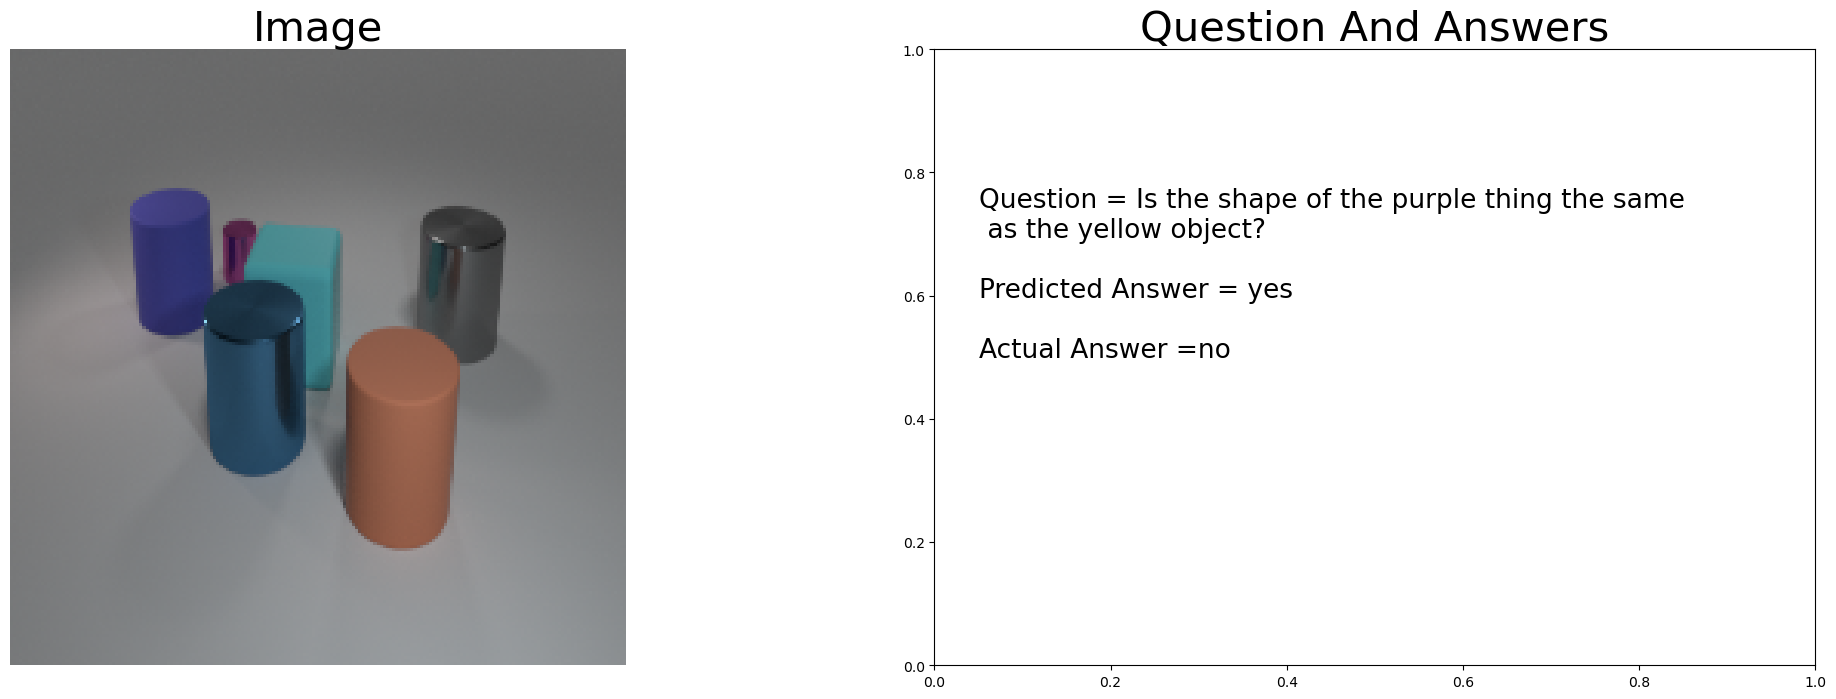

1/1 [==============================] - 0s 50ms/step


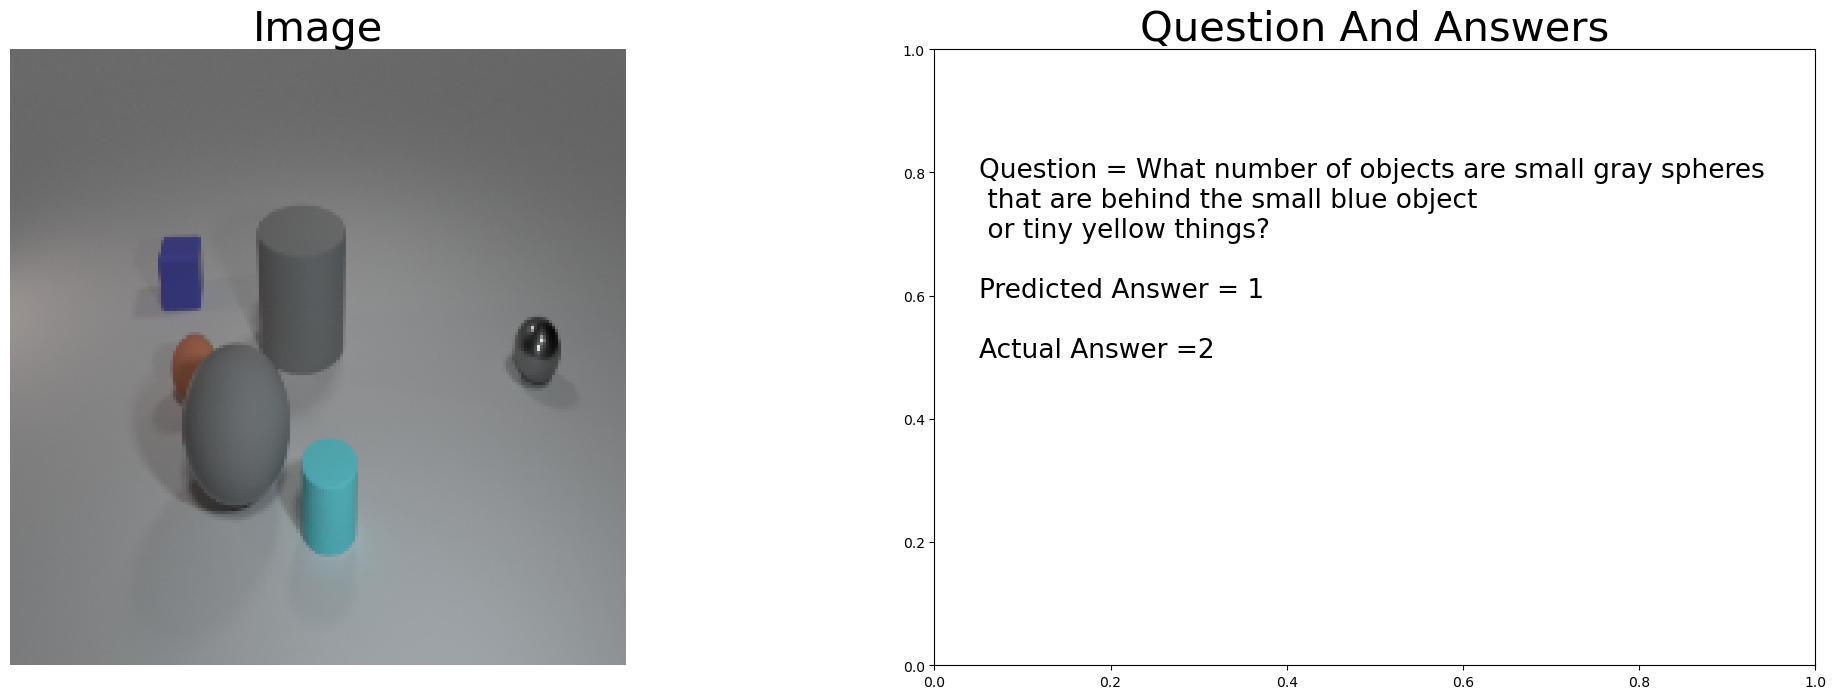

1/1 [==============================] - 0s 50ms/step


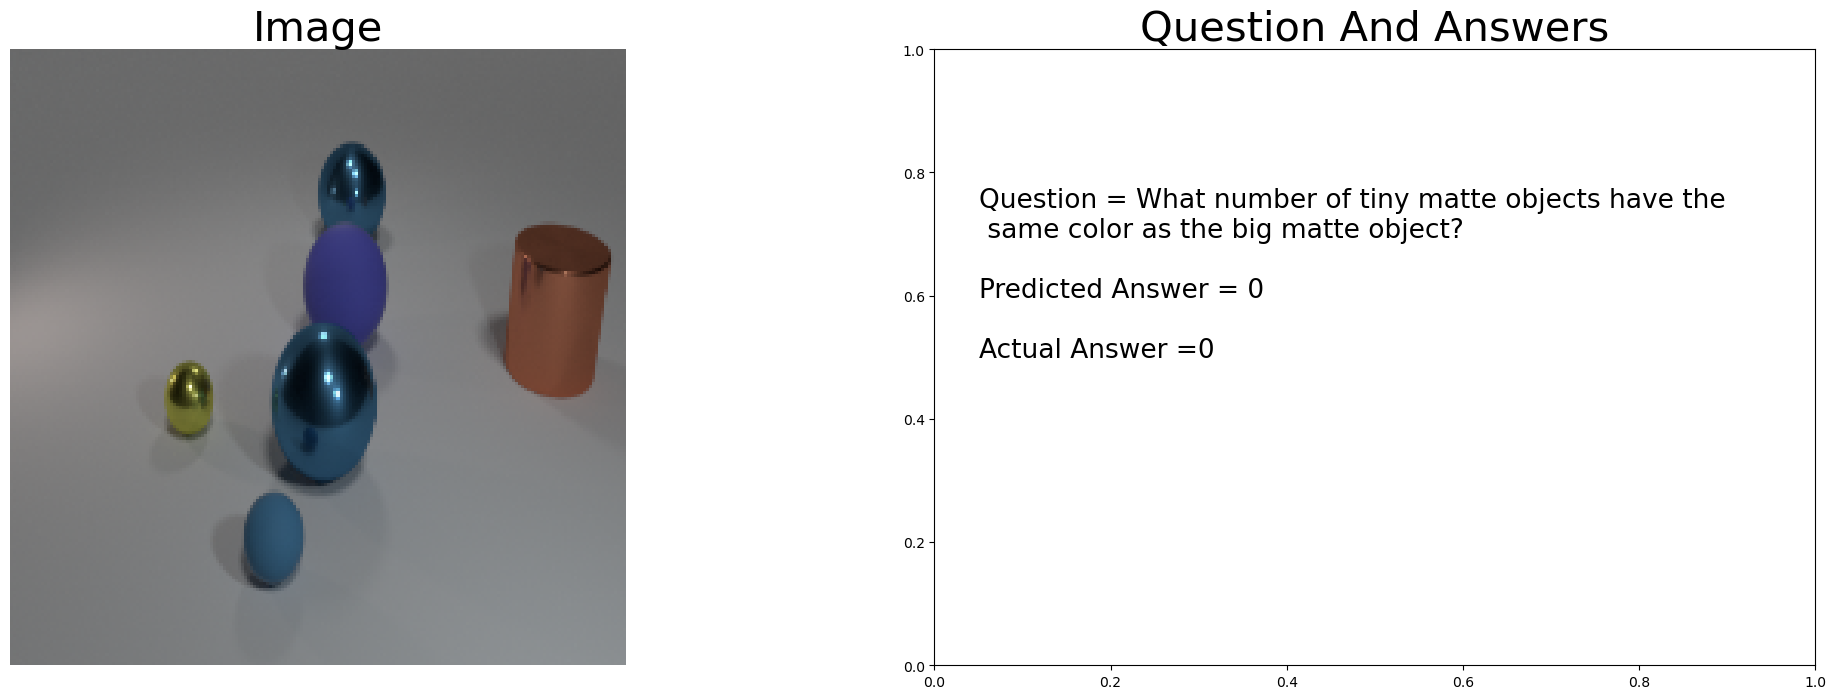

1/1 [==============================] - 0s 52ms/step


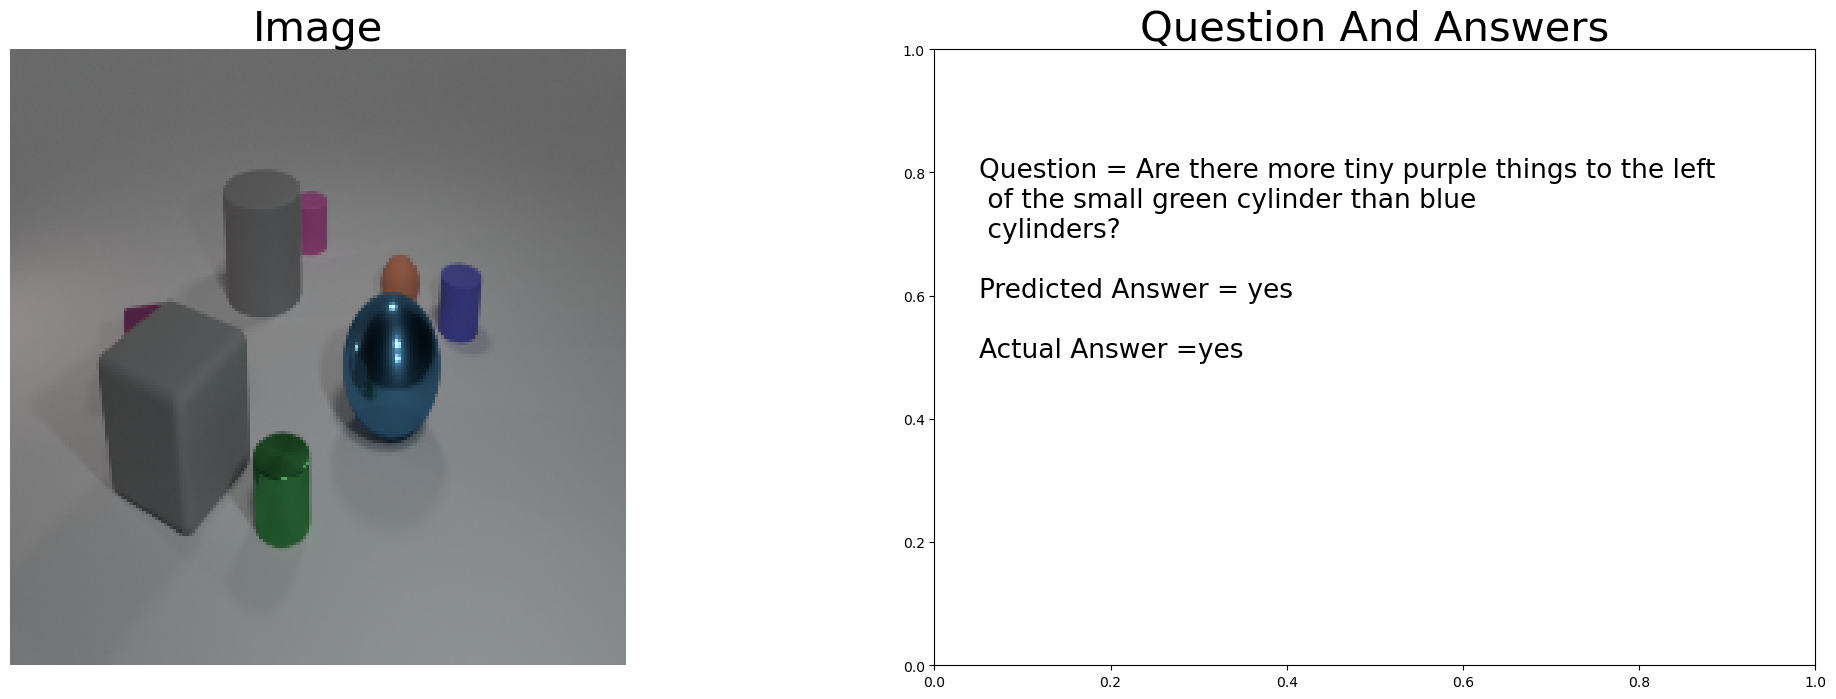

1/1 [==============================] - 0s 52ms/step


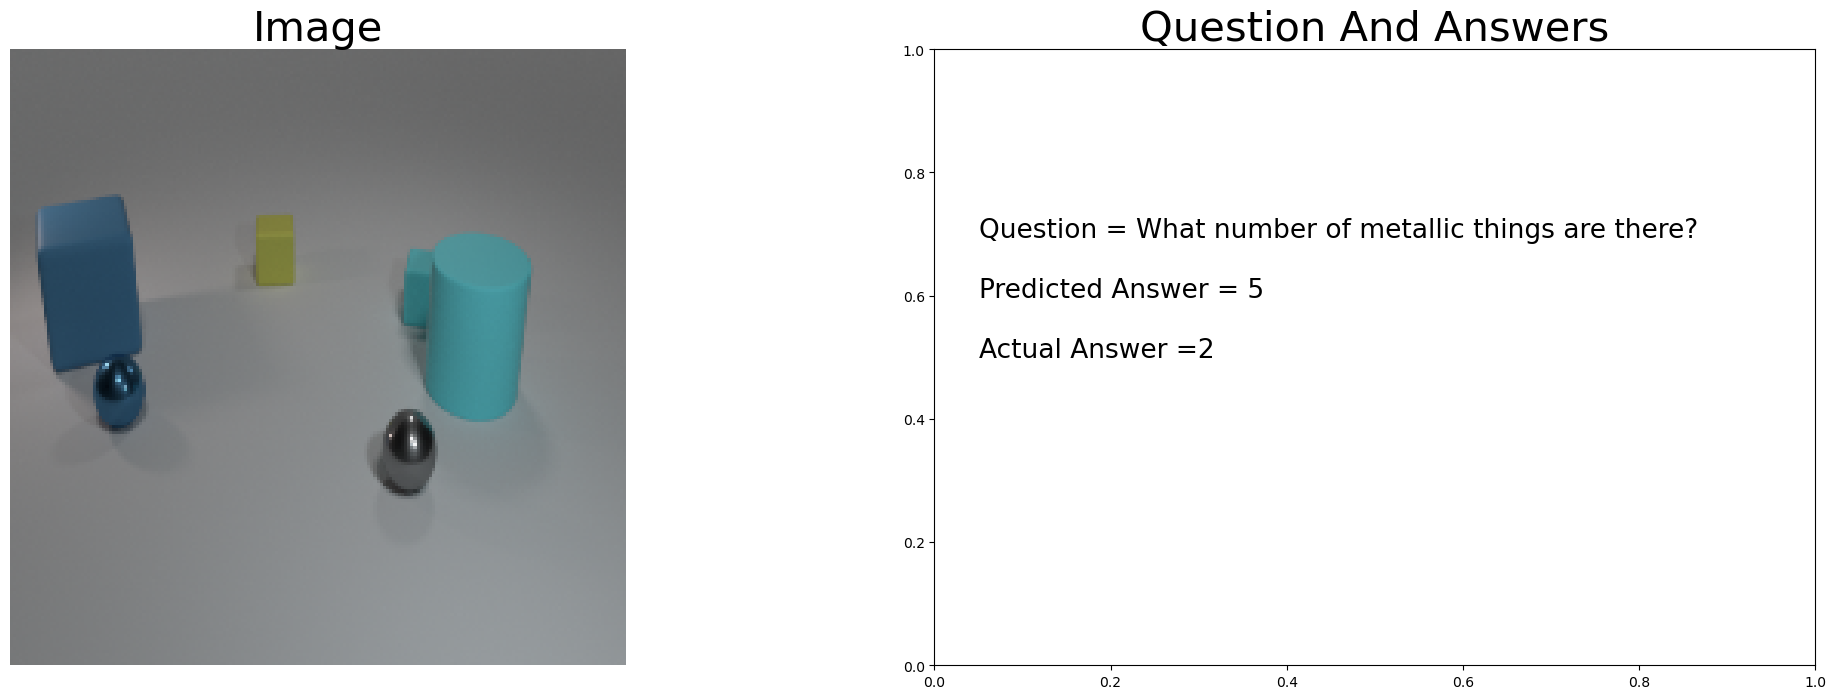

In [57]:
print("Predictions Are as follows = ")
for i in range(5):
    index = random.randrange(20, 5000, 3)
    fig, axis = plt.subplots(1, 2, figsize=(25, 8))

    # Read and preprocess the image
    im = cv2.imread(val_dataframe.iloc[index]['Path'])
    im = cv2.resize(im, (200, 200))
    im = np.expand_dims(im, axis=0)  # Add batch dimension

    # Encode and pad the question
    q = val_dataframe.iloc[index]['Question']
    q = encoder.encode(q)
    paddings = [[0, 50 - tf.shape(q)[0]]]
    q = tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q = np.array(q)
    q = np.expand_dims(q, axis=0)  # Add batch dimension

    # Predict the answer
    ans = model.predict([im, q])

    # Process the question for display
    question = ""
    flag = 0
    for i, j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag == 1) and (j == ' '):
            question += '\n'
            flag = 0
        question += j
        if (i % 40 == 0) and (i != 0):
            flag = 1

    # Display the image
    axis[0].imshow(im[0])  # Adjust for the batch dimension
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)

    # Display the question and answers
    axis[1].text(0.05, 0.5,
                 "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(
                     question, encoder.decode([np.argmax(ans)]), val_dataframe.iloc[index]['Answer']),
                 transform=axis[1].transAxes, fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

    plt.show()